In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import pandas as pd
import scipy.stats
import tensorflow as tf
#import tensorflow_probability as tfp
import scanpy as sc

print()
print("numpy version "+np.__version__)
print("tensorflow version "+tf.__version__)
#print("tensorflow_probability version "+tfp.__version__)


import batchglm.api as glm
import diffxpy.api as de

print("batchglm version "+glm.__version__)
print("diffpy version "+de.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

numpy version 1.18.2
tensorflow version 1.14.0
batchglm version v0.6.8
diffpy version v0.6.13


# load annotated data

The processed file has all the annotations, including the 1D spatial scores.

In [5]:
annot = sc.read_h5ad('/Users/yolanda/Documents/projects/spatial-genomics/data/Processed_Liver_All_Batches_mouse_deconV2_spatial.h5ad')

The raw counts file is the decontaminated data without log normalizing.

In [6]:
adata_matrix = sc.read_h5ad('/Users/yolanda/Documents/projects/spatial-genomics/data/Liver_All_Batches_mouse_deconV2_raw_counts.h5ad')

Among 24914 mm10 transcripts and 5434 cells, filter to retain genes with high expression, and then select the top 2000 most variable genes. 
R scripts:
dim(liver_mat) # 24917 genes by 5434 cells
genes_to_keep <- which(rowSums(edgeR::cpm(liver_mat) > 5) >= 15)
liver_mat_filter_raw <- liver_mat[genes_to_keep, ]
convert to log 2 counts per million
liver_mat_log2 <- edgeR::cpm(liver_mat_filter_raw, log = TRUE)
dim(liver_mat_log2) # 14222 by 5434
Calc_CV <- function(x){sd(x) / mean(x)}
liver_gene_cv <- apply(liver_mat_log2, 1, Calc_CV)
summary(liver_gene_cv)
liver_mat_filter <- liver_mat_log2[which(rank(liver_gene_cv) > length(liver_gene_cv) - 2000), ]

In [12]:
top_variable_genes = pd.read_csv('/Users/yolanda/Documents/projects/spatial-genomics/data/top2000genes.csv')
top_variable_genes['x']

0        mm10_Rb1cc1
1        mm10_Pcmtd1
2         mm10_Cspp1
3       mm10_Arfgef1
4         mm10_Ncoa2
            ...     
1995      mm10_Eif3a
1996       mm10_Grk5
1997     mm10_mt-Co1
1998     mm10_mt-Nd5
1999       mm10_PISD
Name: x, Length: 2000, dtype: object

In [44]:
adata = adata_matrix[adata_matrix.obs.index.isin(annot.obs.index.to_list())]



In [45]:
##set annotations
adata.obs = annot.obs

adata.uns = annot.uns

In [46]:
adata

AnnData object with n_obs × n_vars = 5434 × 55287 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

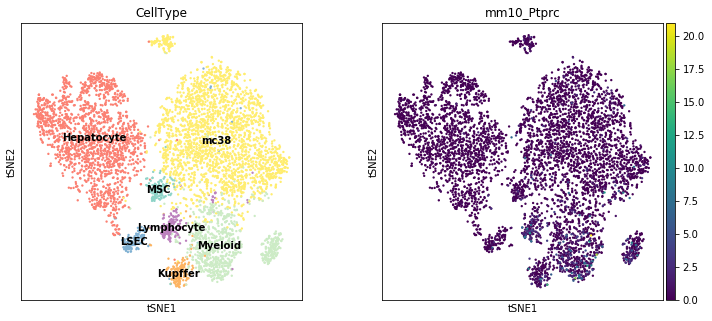

In [47]:
plt.rcParams['figure.figsize'] = [5, 5]

sc.pl.tsne(adata,
          color=['CellType','mm10_Ptprc'],
          legend_loc = 'on data'
          )


In [48]:
## convert float32 matrix to integers 
adata.X =  adata.X.astype(int) 

In [49]:
adata.X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [50]:
adata

AnnData object with n_obs × n_vars = 5434 × 55287 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [51]:
##log normalize 
adata = sc.pp.log1p(adata, copy=True)

In [52]:
## name continuous variable "time" - necessary for diffxpy bug
adata.obs['time'] = adata.obs['prox_2']

In [53]:
##filter out human genes

adata = adata[:,adata.var_names.str.startswith('mm10_')]
adata

View of AnnData object with n_obs × n_vars = 5434 × 24917 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1', 'time'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [55]:
## filter to retain top 2000 most variable genes
adata = adata[:, top_variable_genes['x']]
adata

View of AnnData object with n_obs × n_vars = 5434 × 2000 
    obs: 'batch', 'n_counts', 'log_counts', 'n_genes', 'percent_mito_mouse', 'percent_mito_human', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'contam_post', 'contam_init', 'tsne_density', 'leiden', 'CellType', '__is_in_cluster__', 'barcode', 'X', 'Y', 'prox_1', 'prox_2', 'bins_1', 'time'
    uns: 'CellType_colors', 'batch_colors', 'dendrogram_CellType', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'rank_genes_groups_filtered', 'tsne_density_params', 'umap', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [56]:
## remove cell with nan prox_2 values
adata = adata[~adata.obs['time'].isnull()]

In [57]:
##create species specific matricies

adata_Myeloid = adata[adata.obs['CellType'] == 'Myeloid']

adata_lymphocyte = adata[adata.obs['CellType'] == 'Lymphocyte']

adata_hepatocyte = adata[adata.obs['CellType'] == 'Hepatocyte']

adata_mc38 = adata[adata.obs['CellType'] == 'mc38']


In [58]:

##reassign to fix other diffxpy bug


## name continuous variable "time" - necessary for diffxpy bug
adata_hepatocyte.obs['time'] = adata_hepatocyte.obs['prox_2']

adata_mc38.obs['time'] = adata_mc38.obs['prox_2']

adata_Myeloid.obs['time'] = adata_Myeloid.obs['prox_2']



Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [59]:
### fix integer issue - after log transforming

adata_hepatocyte.X =  adata_hepatocyte.X.astype(int) 

adata_mc38.X =  adata_mc38.X.astype(int) 

adata_Myeloid.X =  adata_Myeloid.X.astype(int) 

In [60]:
adata_Myeloid.X

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [65]:
det_mc38 = de.test.continuous_1d(   
    data=adata_mc38.X,    
    
    sample_description=adata_mc38.obs,
    
    gene_names=adata_mc38.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale= False
)

INFO:tensorflow:Step: 0 loss: 482.696096 models converged 0
INFO:tensorflow:Step: 1 loss: 474.972208, converged 8 in 1.133 sec., updated 1923, {f: 0, g: 8, x: 0}
INFO:tensorflow:Step: 2 loss: 474.166229, converged 8 in 0.708 sec., updated 1874, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 473.980549, converged 8 in 0.729 sec., updated 1909, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 473.870430, converged 20 in 0.721 sec., updated 1919, {f: 12, g: 1, x: 0}
INFO:tensorflow:Step: 5 loss: 473.813753, converged 337 in 0.701 sec., updated 1907, {f: 316, g: 101, x: 0}
INFO:tensorflow:Step: 6 loss: 473.784375, converged 1010 in 0.75 sec., updated 1590, {f: 673, g: 236, x: 0}
INFO:tensorflow:Step: 7 loss: 473.766468, converged 1386 in 0.811 sec., updated 916, {f: 376, g: 137, x: 0}
INFO:tensorflow:Step: 8 loss: 473.754188, converged 1528 in 0.77 sec., updated 538, {f: 142, g: 34, x: 0}
INFO:tensorflow:Step: 9 loss: 473.745119, converged 1570 in 0.769 sec., updated 388, {f: 42, g: 13, 

INFO:tensorflow:Step: 80 loss: 473.714497, converged 1998 in 0.84 sec., updated 2, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 81 loss: 473.714497, converged 1998 in 0.844 sec., updated 1, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 82 loss: 473.714497, converged 1998 in 0.843 sec., updated 2, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 83 loss: 473.714497, converged 1998 in 0.794 sec., updated 2, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 84 loss: 473.714497, converged 1998 in 0.815 sec., updated 2, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 85 loss: 473.714497, converged 1998 in 0.749 sec., updated 1, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 86 loss: 473.714497, converged 1998 in 0.718 sec., updated 2, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 87 loss: 473.714497, converged 1998 in 0.784 sec., updated 0, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 88 loss: 473.714497, converged 1998 in 0.803 sec., updated 1, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 89 loss: 473.714497, converged 1998 in 0.803 sec., u

In [63]:
det_hepatocyte = de.test.continuous_1d(   
    data=adata_hepatocyte.X,    
    
    sample_description=adata_hepatocyte.obs,
    
    gene_names=adata_hepatocyte.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale=False   
)

INFO:tensorflow:Step: 0 loss: 809.481907 models converged 0
INFO:tensorflow:Step: 1 loss: 803.908904, converged 17 in 1.349 sec., updated 1949, {f: 0, g: 17, x: 0}
INFO:tensorflow:Step: 2 loss: 802.840084, converged 17 in 0.835 sec., updated 1810, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 802.501278, converged 17 in 1.086 sec., updated 1822, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 802.301243, converged 17 in 1.437 sec., updated 1837, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 802.178968, converged 17 in 0.972 sec., updated 1842, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 802.107317, converged 17 in 1.195 sec., updated 1839, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 802.069016, converged 17 in 0.947 sec., updated 1829, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 802.049484, converged 17 in 0.958 sec., updated 1823, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 802.037064, converged 17 in 0.864 sec., updated 1819, {f: 0, g: 0, x: 0}
INFO:tensorf

In [69]:
det_Myeloid = de.test.continuous_1d(   
    data=adata_Myeloid.X,    
    
    sample_description=adata_Myeloid.obs,
    
    gene_names=adata_Myeloid.var_names,
    
    formula_loc="~ 1 + time + batch",
    
    formula_scale="~ 1 + batch",
    
    factor_loc_totest="time",

    continuous="time",
#    size_factors=np.random.uniform(0.2, 2, adata_macrophage.n_obs),  
    df=4,
    quick_scale= False  
)

INFO:tensorflow:Step: 0 loss: 538.285182 models converged 0
INFO:tensorflow:Step: 1 loss: 529.221597, converged 75 in 0.946 sec., updated 1903, {f: 0, g: 75, x: 0}
INFO:tensorflow:Step: 2 loss: 527.218669, converged 75 in 0.469 sec., updated 1798, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 3 loss: 526.615216, converged 75 in 0.468 sec., updated 1802, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 4 loss: 526.285725, converged 75 in 0.417 sec., updated 1808, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 5 loss: 526.061059, converged 75 in 0.461 sec., updated 1817, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 6 loss: 525.926795, converged 75 in 0.464 sec., updated 1818, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 7 loss: 525.857831, converged 75 in 0.46 sec., updated 1816, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 8 loss: 525.823047, converged 75 in 0.448 sec., updated 1808, {f: 0, g: 0, x: 0}
INFO:tensorflow:Step: 9 loss: 525.801063, converged 75 in 0.488 sec., updated 1800, {f: 0, g: 0, x: 0}
INFO:tensorfl

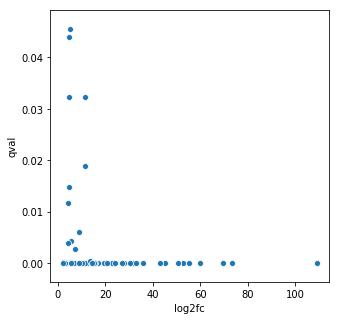

In [70]:
sns.scatterplot(data=det_Myeloid.summary()[det_Myeloid.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

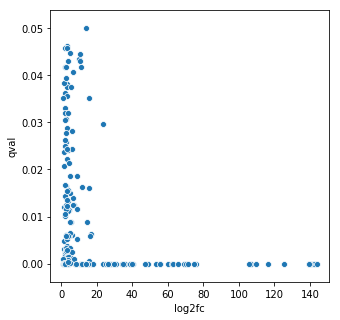

In [71]:
sns.scatterplot(data=det_mc38.summary()[det_mc38.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

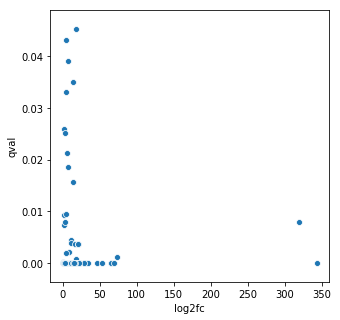

In [72]:
sns.scatterplot(data=det_hepatocyte.summary()[det_hepatocyte.summary()['qval'] <= 0.05],
               x='log2fc',
               y='qval')

In [ ]:
# 'mm10_Tgfbi','mm10_Rpl8','mm10_Cd74','mm10_Hsp90ab1','mm10_Rnf213' 
# 'mm10_Zbtb20','mm10_Ghr','mm10_Dpyd','mm10_Adk','mm10_Akap9','mm10_Xist','mm10_Col1a2','mm10_Plcb1','mm10_Exoc4 mm10_St3gal4 mm10_Pnisr mm10_Foxp1 mm10_Gpc6 mm10_AY036118 mm10_Immp2l mm10_Chd9 mm10_Ly6e 
# 'mm10_Lgals1','mm10_B2m','mm10_Rpsa','mm10_Vim 
# 'mm10_Plec','mm10_Ahnak mm10_Tcf20','mm10_Cdk6','mm10_Rrbp1','mm10_Serbp1','mm10_Ncl 
# 'mm10_Zfpm2','mm10_Dpysl3','mm10_Samd4','mm10_Zfhx3','mm10_Fam19a1','mm10_Luc7l3','mm10_Pakap','mm10_Slit2 mm10_Myo10 
# 'mm10_Cald1','mm10_Erdr1','mm10_Gnas
# 'mm10_Airn','mm10_Tcf4','mm10_Smg6','mm10_Cpq','mm10_Ldlrad4','mm10_Dclk1','mm10_PISD','mm10_Kif26b','mm10_Trps1','mm10_Nfia','mm10_Sdc2','mm10_Pde4d
# 'mm10_Col3a1','mm10_Rpl4','mm10_Myh9','mm10_Smc4','mm10_Dst','mm10_Whsc1 

In [73]:
##qval cutoff
gene_frame_Myeloid = det_Myeloid.summary()[det_Myeloid.summary().sort_values('qval', )['qval'] <= 0.05]
gene_frame_mc38 = det_mc38.summary()[det_mc38.summary().sort_values('qval', )['qval'] <= 0.05]

gene_frame_hepatocyte = det_hepatocyte.summary()[det_hepatocyte.summary().sort_values('qval', )['qval'] <= 0.05]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [75]:
##fold change cutoff
gene_frame_2_Myeloid = gene_frame_Myeloid[gene_frame_Myeloid.log2fc >= 2]
gene_frame_2_mc38 = gene_frame_mc38[gene_frame_mc38.log2fc >= 2]
gene_frame_2_hepatocyte = gene_frame_hepatocyte[gene_frame_hepatocyte.log2fc >= 2]

In [772]:
#gene_frame_2 = gene_frame_2[gene_frame_2.grad < 0.02]

In [773]:
#gene_frame_2 = gene_frame_2[gene_frame_2.log2fc < 7]

In [78]:
#get gene ids in list


gene_idx_Myeloid = det_Myeloid._idx_genes(
    
    genes=gene_frame_2_Myeloid['gene'].tolist()

)

gene_idx_mc38 = det_mc38._idx_genes(
    
    genes=gene_frame_2_mc38['gene'].tolist()

)

gene_idx_hepatocyte = det_hepatocyte._idx_genes(
    
    genes=gene_frame_2_hepatocyte['gene'].tolist()

)

gene_idx_hepatocyte

array([  43,   54,   70,   72,   92,  102,  103,  198,  312,  369,  376,
        385,  399,  457,  479,  481,  483,  589,  593,  615,  624,  625,
        628,  641,  650,  653,  678,  701,  702,  760,  787,  800,  852,
        855,  868,  879, 1010, 1037, 1058, 1061, 1062, 1075, 1156, 1163,
       1216, 1231, 1245, 1254, 1279, 1290, 1349, 1367, 1385, 1389, 1415,
       1465, 1475, 1476, 1483, 1566, 1647, 1649, 1651, 1652, 1658, 1671,
       1748, 1751, 1777, 1796, 1803, 1864, 1866, 1886, 1902, 1937, 1942,
       1950, 1962, 1975, 1976, 1984])

In [79]:
### get continuous interpolation
xcoord_Myeloid, data_Myeloid = det_Myeloid._continuous_interpolation(idx=gene_idx_Myeloid)
xcoord_mc38, data_mc38 = det_mc38._continuous_interpolation(idx=gene_idx_mc38)
xcoord_hepatocyte, data_hepatocyte = det_hepatocyte._continuous_interpolation(idx=gene_idx_hepatocyte)

In [80]:
### after tranforming, data has number of values, equal to filtered results
data_Myeloid = data_Myeloid.T
data_mc38 = data_mc38.T
data_hepatocyte = data_hepatocyte.T

In [81]:
temp_Myeloid=pd.DataFrame(data_Myeloid)
temp_mc38=pd.DataFrame(data_mc38)
temp_hepatocyte=pd.DataFrame(data_hepatocyte)

In [82]:
temp_Myeloid.index = det_Myeloid.summary().iloc[list(gene_idx_Myeloid)]['gene'].str[5:]
temp_mc38.index = det_mc38.summary().iloc[list(gene_idx_mc38)]['gene'].str[5:]
temp_hepatocyte.index = det_hepatocyte.summary().iloc[list(gene_idx_hepatocyte)]['gene'].str[5:]

In [83]:
##max value across columns 
# sort_order = temp.idxmax(axis=1)
# sort_order=sort_order.sort_values().index

# temp = temp.reindex(sort_order)

In [780]:
# temp.inde

In [84]:
temp_2_Myeloid = temp_Myeloid.div(temp_Myeloid.sum(axis=1), axis=0)
temp_2_mc38 = temp_mc38.div(temp_mc38.sum(axis=1), axis=0)
temp_2_hepatocyte = temp_hepatocyte.div(temp_hepatocyte.sum(axis=1), axis=0)

In [85]:
temp_3_Myeloid=temp_2_Myeloid[~(temp_2_Myeloid > 0.02).any(1)]
temp_3_mc38=temp_2_mc38[~(temp_2_mc38 > 0.02).any(1)]
temp_3_hepatocyte=temp_2_hepatocyte[~(temp_2_hepatocyte > 0.02).any(1)]

In [86]:
temp_3_Myeloid.shape

(7, 100)

In [87]:
temp_3_mc38.shape

(66, 100)

In [88]:
temp_3_hepatocyte.shape

(12, 100)

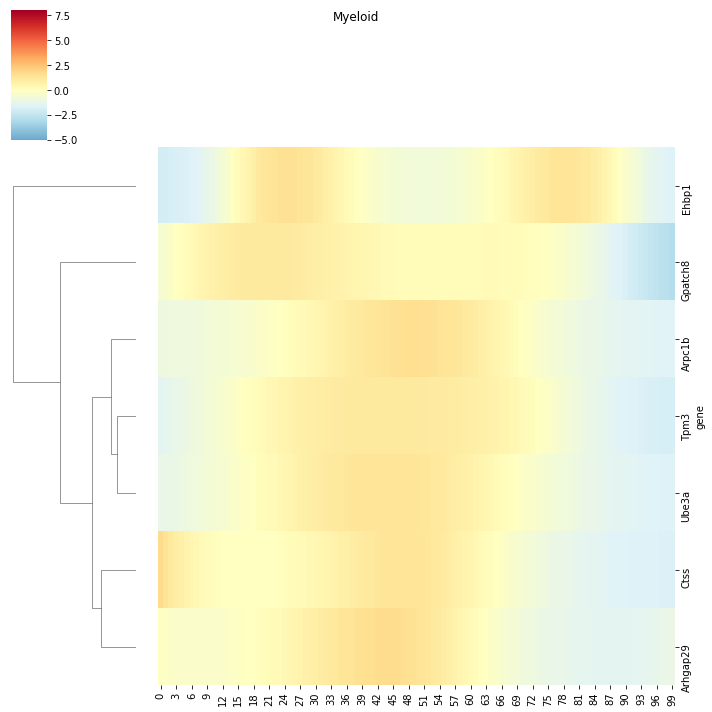

In [101]:
plt.rcParams['figure.figsize'] = [10, 20]

# z_scoreint or None, optional
# Either 0 (rows) or 1 (columns).





g_Myeloid =sns.clustermap(data=temp_3_Myeloid,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_Myeloid.fig.suptitle('Myeloid') 

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_Myeloid.svg', bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_Myeloid.png', bbox_inches='tight')


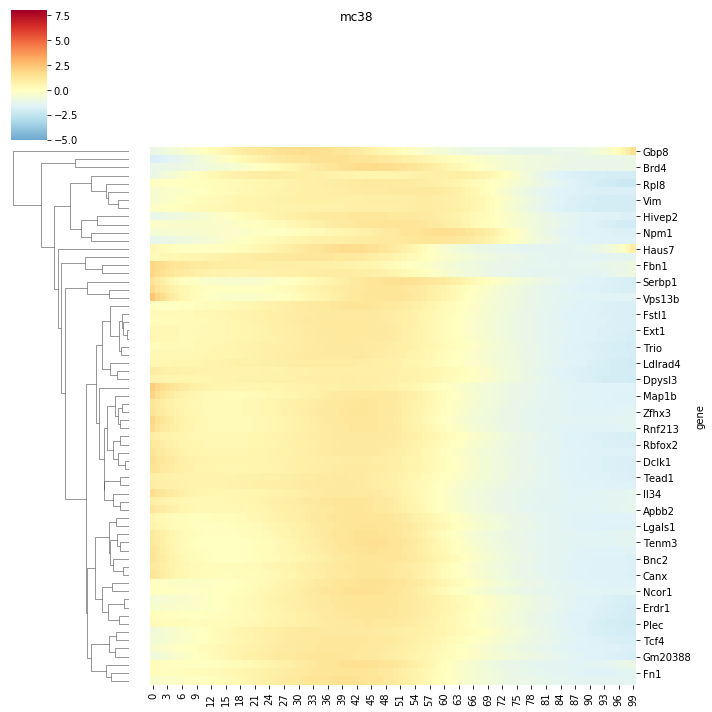

In [99]:
g_mc38 =sns.clustermap(data=temp_3_mc38,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_mc38.fig.suptitle('mc38') 

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_mc38.svg', bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_mc38.png', bbox_inches='tight')


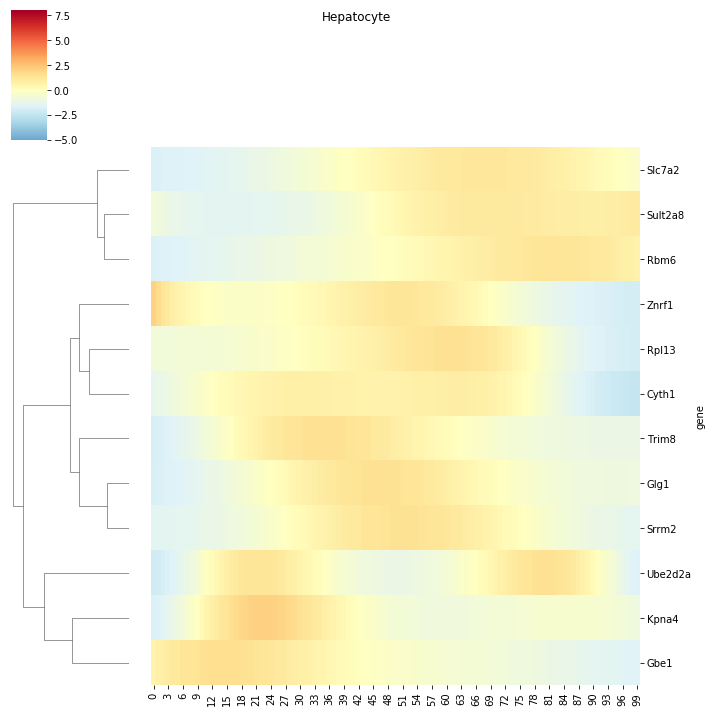

In [97]:
g_hepatocyte =sns.clustermap(data=temp_3_hepatocyte,
             metric='cityblock', #defualt euclidean   #canberra
             method='average',
            z_score=0,
           cmap='RdYlBu_r',
            vmax=8,
            vmin=-5,
            center=0,
               col_cluster=False      
           )
g_hepatocyte.fig.suptitle('Hepatocyte') 

plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_hepatocyte.svg', bbox_inches='tight')
plt.savefig('/Users/yolanda/Documents/Github/spatial-genomics/fig/fig4c/heatmap_spatial_hepatocyte.png', bbox_inches='tight')


Yutong did not revise the scripts below yet. 

TBC ... 

-------------------------------------------------------

In [801]:
from gprofiler import GProfiler


In [858]:
gp = GProfiler(return_dataframe=True)
gp.profile(organism='mmusculus',
            query=group_1
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,HP,HP:0003564,Folate-dependent fragile site at Xq28,0.049859,True,The presence of a folate sensitive fragile sit...,1,1,1,4457,1.0,1.0,query_1,[HP:0040012]
1,HP,HP:0008640,Congenital macroorchidism,0.049859,True,Congenital macroorchidism,1,1,1,4457,1.0,1.0,query_1,[HP:0000053]


In [859]:
gp.profile(organism='mmusculus',
            query=group_2
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents


In [860]:
gp.profile(organism='mmusculus',
            query=group_3
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,CORUM,CORUM:7492,Bcl2-Becn1 complex,0.049746,True,Bcl2-Becn1 complex,2,1,1,1058,1.0,0.5,query_1,[CORUM:0000000]


In [861]:
gp.profile(organism='mmusculus',
            query=group_4
          )

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:1904888,cranial skeletal system development,0.002028,True,"""The process whose specific outcome is the pro...",68,25,4,21331,0.16,0.058824,query_1,[GO:0048856]
1,GO:BP,GO:0048704,embryonic skeletal system morphogenesis,0.009522,True,"""The process in which the anatomical structure...",100,25,4,21331,0.16,0.040000,query_1,"[GO:0048562, GO:0048705, GO:0048706]"
2,GO:BP,GO:0048706,embryonic skeletal system development,0.029475,True,"""The process, occurring during the embryonic p...",133,25,4,21331,0.16,0.030075,query_1,"[GO:0001501, GO:0043009]"
3,GO:BP,GO:0048701,embryonic cranial skeleton morphogenesis,0.042417,True,"""The process in which the anatomical structure...",48,25,3,21331,0.12,0.062500,query_1,"[GO:0048704, GO:1904888]"


In [845]:
color_list = []

from pylab import *

cmap = cm.get_cmap('Set3', 20)

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    color_list.append(matplotlib.colors.rgb2hex(rgb))
    print(matplotlib.colors.rgb2hex(rgb))

#8dd3c7
#8dd3c7
#ffffb3
#ffffb3
#bebada
#fb8072
#fb8072
#80b1d3
#fdb462
#fdb462
#b3de69
#b3de69
#fccde5
#d9d9d9
#d9d9d9
#bc80bd
#ccebc5
#ccebc5
#ffed6f
#ffed6f


In [846]:
###expand colors of dendrogram link

import matplotlib as mpl
from matplotlib.pyplot import cm
from scipy.cluster import hierarchy

hierarchy.set_link_color_palette(color_list)

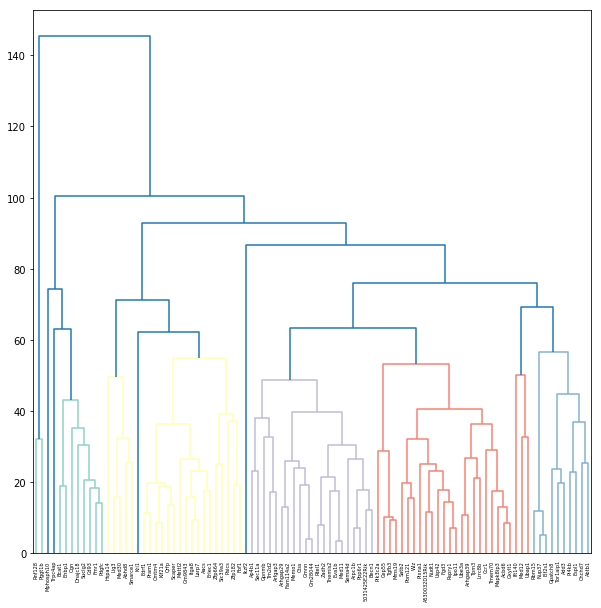

In [849]:
plt.rcParams['figure.figsize'] = [10, 10]

den = scipy.cluster.hierarchy.dendrogram(g.dendrogram_row.linkage,
                                         labels = temp_3.index,
                                         color_threshold=60)  



In [850]:
from collections import defaultdict

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = {}
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l

    return cluster_classes

In [851]:
clusters = get_cluster_classes(den)

cluster = []
for i in temp_3.index:
    included=False
    for j in clusters.keys():
        if i in clusters[j]:
            cluster.append(j)
            included=True
    if not included:
        cluster.append(None)

# df["cluster"] = cluster

In [852]:
len(clusters.keys()) # ['#8000ff']

6

In [853]:
import pandas as pd

In [854]:
valuesA = []


for key, value in clusters.items():
    for indexx in value:
        temp = [indexx, key]
        valuesA.append(temp)

In [855]:
index_color = pd.DataFrame(np.matrix(valuesA))
index_color.columns=['indices', 'color']

array(['#8dd3c7', 'C0', '#ffffb3', '#bebada', '#fb8072', '#80b1d3'],
      dtype=object)

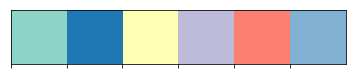

In [856]:
sns.palplot(index_color['color'].unique())
index_color['color'].unique()

In [857]:
group_0 =temp_3[temp_3.index.isin(clusters['C0'])].index.tolist()
group_1 =temp_3[temp_3.index.isin(clusters['#8dd3c7'])].index.tolist()
group_2 =temp_3[temp_3.index.isin(clusters['#ffffb3'])].index.tolist()
group_3 =temp_3[temp_3.index.isin(clusters['#bebada'])].index.tolist()
group_4 =temp_3[temp_3.index.isin(clusters['#fb8072'])].index.tolist()

In [621]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#8dd3c7'])]

In [622]:
genedf

,gene,pval,qval,log2fc,mean,zero_mean,grad,ll


In [450]:
#genedf.mean(axis=0)

In [451]:
comparison_df = pd.DataFrame(genedf.median(axis=0),columns=['1'])

In [452]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#ffffb3'])]

In [453]:
#genedf.mean(axis=0)

In [454]:
comparison_df['2'] = pd.DataFrame(genedf.median(axis=0),columns=['2'])

In [455]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#bebada'])]

In [456]:
#genedf.mean(axis=0)

In [457]:
comparison_df['3'] = pd.DataFrame(genedf.median(axis=0),columns=['3'])

In [458]:
genedf = gene_frame[gene_frame.reset_index(drop=True)['gene'].index.isin(clusters['#fb8072'])]

In [459]:
#genedf.mean(axis=0)

In [460]:
comparison_df['4'] = pd.DataFrame(genedf.median(axis=0),columns=['4'])

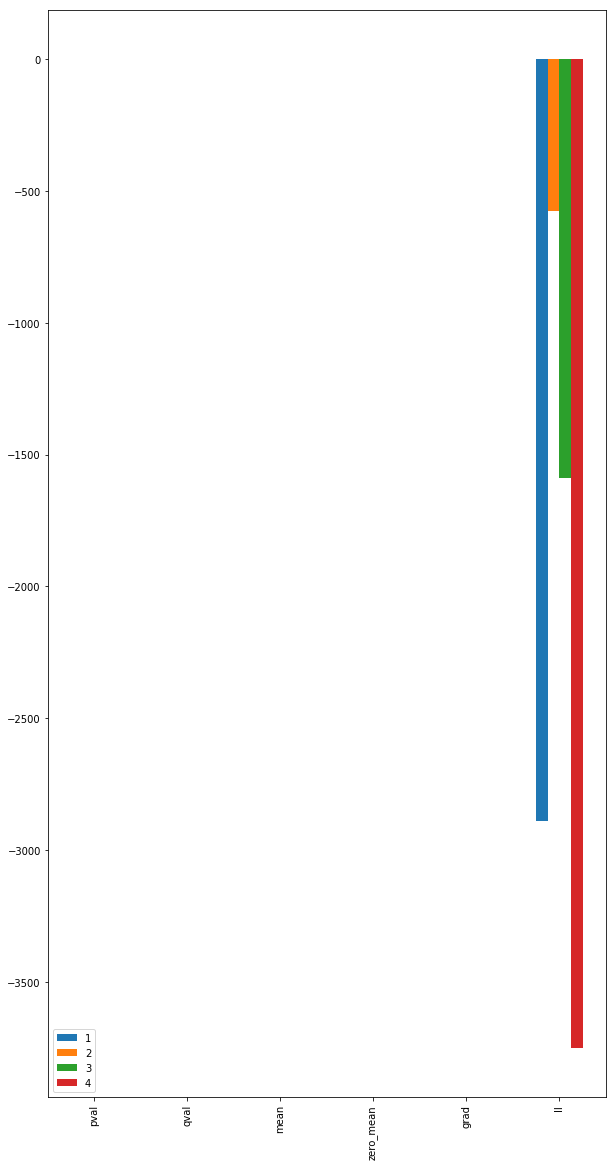

In [660]:
comparison_df.drop(['log2fc'],axis=0).plot.bar()